In [76]:
# lstm model
from numpy import dstack
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools


In [20]:
def load_file(filepath):
    df = pd.read_fwf(filepath, header=None, delim_whitespace=True)
    return df.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
        # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)  
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    
    return X, y

def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print('dataset shape: ', 'train X',trainX.shape,'train y', trainy.shape, 'test X',testX.shape,'test y' ,testy.shape)
    return trainX, trainy, testX, testy

In [27]:
train_X, train_y, X_test, y_test = load_dataset()

dataset shape:  train X (7352, 128, 9) train y (7352, 6) test X (2947, 128, 9) test y (2947, 6)


In [28]:
# split for validation
test_X, val_X, test_y, val_y = train_test_split(X_test, y_test)
print('dataset shape: ', 'test X', test_X.shape,'test y', test_y.shape, 'val X', val_X.shape,'val y' ,val_y.shape)

dataset shape:  test X (2210, 128, 9) test y (2210, 6) val X (737, 128, 9) val y (737, 6)


In [33]:
verbose, epochs, batch_size = 0, 15, 64
n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[2], train_y.shape[1]

model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.6))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, train_acc = model.evaluate(train_X, train_y, batch_size=batch_size, verbose=0)
_, test_acc = model.evaluate(test_X, test_y, batch_size=batch_size, verbose=0)
print('Train Accuracy: ', train_acc*100, '%', ' Test Accuracy: ', test_acc*100, '%')

Train Accuracy:  94.5048987865448 %  Test Accuracy:  90.45248627662659 %


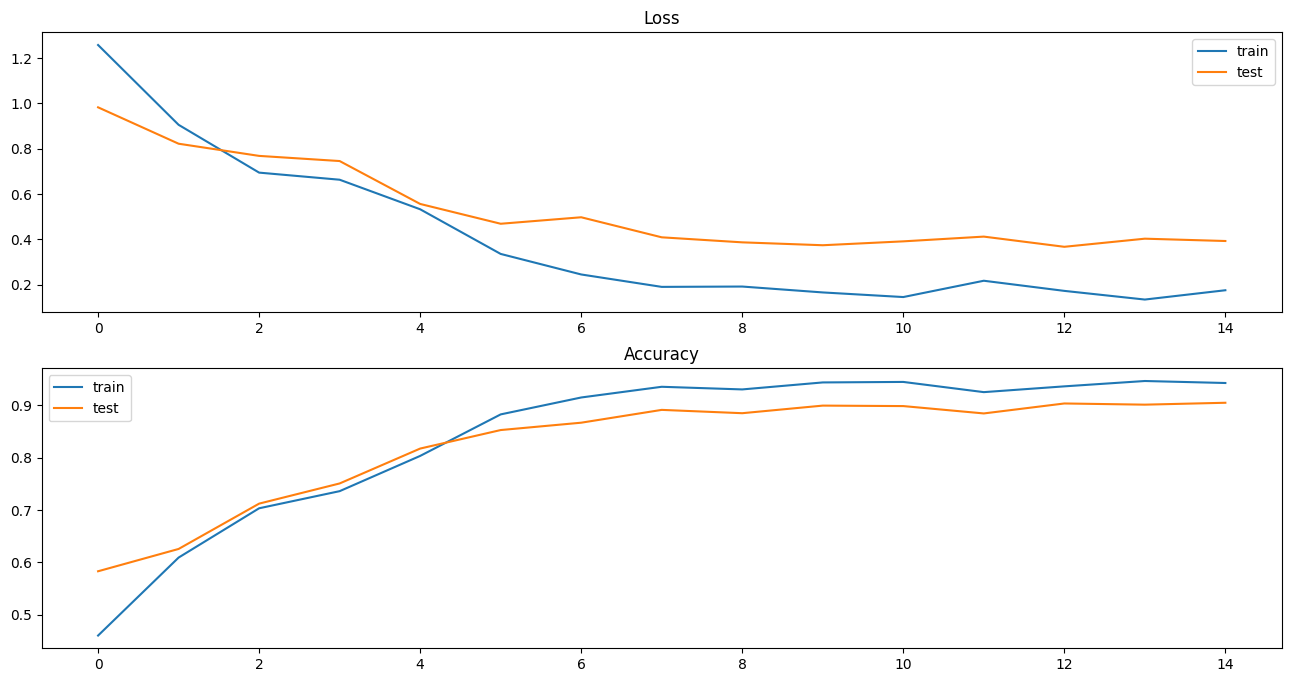

In [37]:
pyplot.figure(figsize=(16,8))

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [73]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

--------------------
| Confusion Matrix |
--------------------

 [[142   1   3   0   0   0]
 [  0 110  10   0   0   0]
 [  2   1 110   0   0   0]
 [  0   1   0  96  21   3]
 [  0   0   0  11  95   0]
 [  0   6   0   0   0 125]]


/tmp/ipykernel_5074/1576893476.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


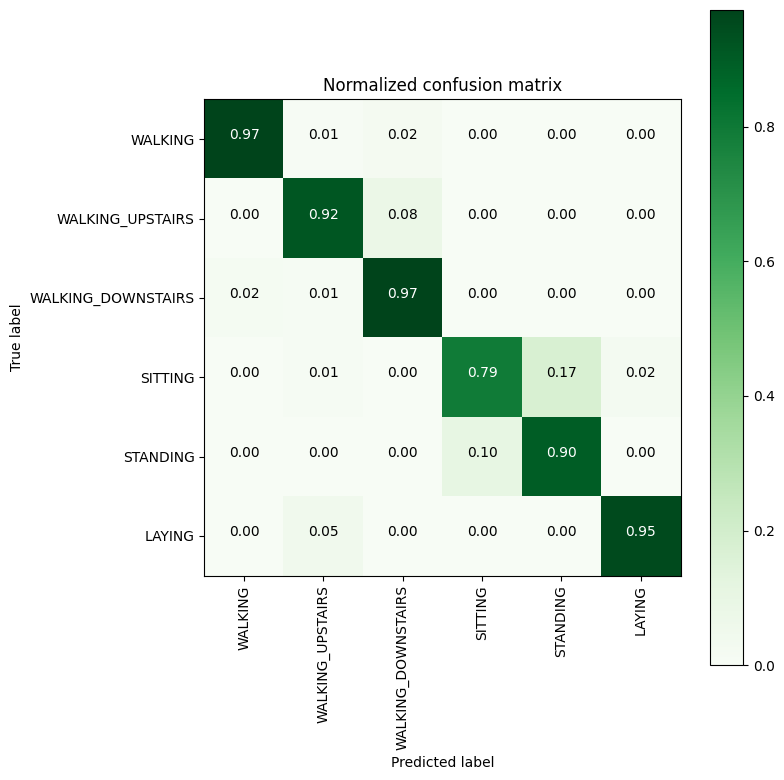

In [77]:
labels = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']

predict = model.predict(val_X,  batch_size=128, verbose=0)
val_pred = np.argmax(predict, axis=1)
val_true = np.argmax(val_y, axis=1)

cm = confusion_matrix(val_true, val_pred)

print('--------------------')
print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))
        
# plot confusin matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix', cmap=plt.cm.Greens)
plt.show()